In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from fiona.crs import from_epsg
import json

In [2]:
from ipyleaflet import Map, GeoData, GeoJSON, basemaps, basemap_to_tiles, Icon, Circle, Marker, LayerGroup, WidgetControl
from ipywidgets import Button 
import ipywidgets as widgets

In [3]:
#drawing basic map
center = (40.7210907,-73.9877836)
basemap = basemap_to_tiles(basemaps.CartoDB.Positron)

icon = Icon(icon_url='icon.png', icon_size=[15, 15])
marker = Marker(location=center, draggable=False, icon=icon, opacity = 0.8)

m = Map(layers=(basemap, ), center=center, zoom=15, min_zoom = 11, max_zoom = 20)

###HALF-MI BUFFER
#set location of center as location of the point
markerlocation=marker.location
print(markerlocation)
    
radius = 402 #in-meters
color = "black"
fill_color = "white"
fill_opacity = .2
weight = 2

##click on map to add marker, removes old marker as well
def handle_click(**kwargs):
    if kwargs.get('type') == 'click':
        layer_group.clear_layers();
        marker = Marker(location=kwargs.get('coordinates'), draggable=False, icon=icon, opacity = 0.8)
        layer_group.add_layer(marker)
        
        #updating the circle's location
        markerlocation=marker.location
        circle.location = markerlocation
        layer_group.add_layer(circle);
        
m.on_interaction(handle_click)
######

#create half-mi buffer
circle = Circle()
circle.location = markerlocation
circle.radius = radius
circle.color = color
circle.fill_color = fill_color
circle.fill_opacity = fill_opacity
circle.weight = weight
###########

    
# def on_location_changed(event):
# #remove any circles existing first
#     layer_group.clear_layers();

# #update location of center as location of the point
#     markerlocation = marker.location
#     circle.location = markerlocation
#     layer_group.add_layer(circle);
        
# pass
# marker.observe(on_location_changed, 'location')
# #######


# #adding button that performs the analysis on click 
# button = Button(description="Reset")

# def on_button_clicked(b, geo_json):   
    
# button.on_click(on_button_clicked)

    
# widget_control = WidgetControl(widget=button, position='topright')
# m.add_control(widget_control)


layer_group = LayerGroup(layers=(marker, circle))
m.add_layer(layer_group)

display(m)

[40.7210907, -73.9877836]


Map(center=[40.7210907, -73.9877836], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [4]:
#extracting the marker location for the buffer
location = markerlocation.copy()

df2 = pd.DataFrame(location)
print(df2)

df=df2.transpose()
df.columns=['Latitude','Longitude']
df.head()

           0
0  40.721091
1 -73.987784


,Latitude,Longitude
0,40.721091,-73.987784


In [5]:
#creating a geodataframe from the point
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

gdf.plot()
# gdf.crs = 'EPSG:4326'
gdf.crs = from_epsg(3857)
print(gdf.crs)

{'init': 'epsg:3857', 'no_defs': True}


In [6]:
test=gdf.copy()

# test.crs = from_epsg(3857)

test.crs = from_epsg(54032)

print(test.crs)
#change to aeqd

{'init': 'epsg:54032', 'no_defs': True}


In [7]:
#making buffer

test['geometry'] = test.geometry.buffer(.004,  cap_style=1, join_style=1)

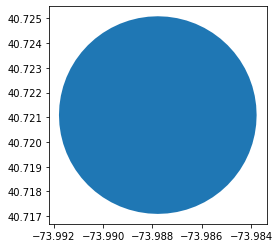

In [8]:
# change back
test.crs = from_epsg(3857)

test.plot()

In [60]:
rect_orig=gdf.copy()
rect_orig['geometry'] = rect_orig.geometry.buffer(4,  cap_style=1, join_style=1)

# rect=rect_orig.envelope
# rect.plot()

diff = gpd.overlay(rect_orig, test, how='difference')

In [63]:
from shapely.geometry import Polygon

geo_data = GeoData(geo_dataframe = diff,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')


m.add_layer(geo_data)
# m.add_control(LayersControl())

m

Map(center=[55.3791104480105, 193.00781250000003], controls=(ZoomControl(options=['position', 'zoom_in_text', …

0    POLYGON ((4.37718 50.85446, 13.40776 52.51817,...
Name: geometry, dtype: geometry


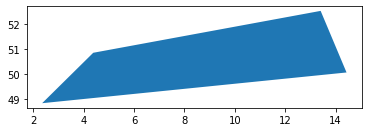

In [53]:
lat_point_list = [50.854457, 52.518172, 50.072651, 48.853033, 50.854457]
lon_point_list = [4.377184, 13.407759, 14.435935, 2.349553, 4.377184]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
print(polygon.geometry)

polygon.plot()

In [18]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point

proj_wgs84 = pyproj.Proj(init='epsg:4326')


def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

# Example
b = geodesic_point_buffer(45.4, -75.7, 100.0)

# print(b)

df3 = pd.DataFrame(b)
print(df3)

df=df2.transpose()
df.columns=['Latitude','Longitude']
df.head()

geo_data = GeoData(geo_dataframe = b,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')


m.add_layer(geo_data)
# m.add_control(LayersControl())

m

TraitError: The 'geo_dataframe' trait of a GeoData instance must be a GeoDataFrame, but a value of class 'list' (i.e. [(-74.42290765358695, 45.39286001598599), (-74.43102886629593, 45.304749544147974), (-74.45130435882973, 45.21762060436458), (-74.48348547224315, 45.1323057616408), (-74.52721388370169, 45.049616639284274), (-74.5820268153558, 44.97033651421593), (-74.64736296746827, 44.89521329343101), (-74.72256907268554, 44.824952917920506), (-74.8069069756517, 44.76021323382723), (-74.89956115070326, 44.701598364618334), (-74.99964657960545, 44.64965361264617), (-75.10621692071173, 44.604860913649276), (-75.21827291013554, 44.56763486349806), (-75.33477094417532, 44.53831933277375), (-75.45463180005838, 44.517184681533564), (-75.5767494588547, 44.504425583792866), (-75.7, 44.50015946877779), (-75.82325054114528, 44.504425583792866), (-75.94536819994161, 44.517184681533564), (-76.06522905582467, 44.538319332773746), (-76.18172708986447, 44.56763486349807), (-76.29378307928829, 44.604860913649276), (-76.40035342039455, 44.64965361264617), (-76.50043884929676, 44.701598364618334), (-76.59309302434829, 44.76021323382723), (-76.67743092731446, 44.824952917920506), (-76.75263703253174, 44.89521329343102), (-76.8179731846442, 44.97033651421592), (-76.87278611629831, 45.049616639284274), (-76.91651452775687, 45.132305761640794), (-76.94869564117027, 45.21762060436459), (-76.96897113370407, 45.304749544147974), (-76.97709234641306, 45.39286001598599), (-76.97292466027376, 45.48110624570844), (-76.95645092776701, 45.568637249705766), (-76.92777384846646, 45.65460503368619), (-76.88711718082747, 45.73817291482957), (-76.83482569028662, 45.818523884534166), (-76.77136374625024, 45.894868922384475), (-76.6973124977633, 45.96645516633109), (-76.61336557957326, 46.03257383970781), (-76.52032332664515, 46.09256783295951), (-76.41908550536326, 46.14583883713008), (-76.31064260280758, 46.19185392753323), (-76.19606575048921, 46.230151499801956), (-76.07649539441185, 46.26034646679444), (-75.95312885778955, 46.28213463363224), (-75.82720697461527, 46.29529617934927), (-75.7, 46.299698187008225), (-75.57279302538474, 46.29529617934927), (-75.44687114221045, 46.28213463363223), (-75.32350460558816, 46.26034646679444), (-75.20393424951081, 46.230151499801956), (-75.08935739719243, 46.19185392753323), (-74.98091449463675, 46.145838837130086), (-74.87967667335485, 46.09256783295952), (-74.78663442042675, 46.03257383970781), (-74.7026875022367, 45.966455166331095), (-74.62863625374976, 45.894868922384475), (-74.56517430971338, 45.818523884534166), (-74.51288281917255, 45.73817291482959), (-74.47222615153356, 45.654605033686195), (-74.443549072233, 45.56863724970577), (-74.42707533972624, 45.481106245708446), (-74.42290765358695, 45.392860015985995), (-74.42290765358695, 45.39286001598599)]) was specified.

In [ ]:
#Make vector that covers the entirety of base map extent 
#calculate difference with the circle 
#then you have the highlighted map


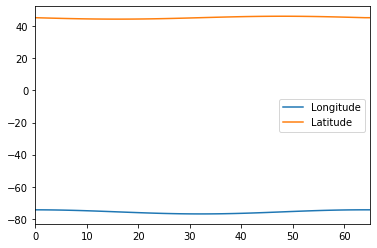

In [26]:
df3 = pd.DataFrame(b)
# print(df3)
# df4=df3.transpose()
df3.columns=['Longitude','Latitude']
df3.head()

df3.plot()

In [27]:
import numpy as np

bufferLength = 100  # 0.1 km
polygonSides = 360

x = 915884
y = 5042490

angles = np.linspace(0, 2 * np.pi, polygonSides, endpoint=False)
points_list = [(x + np.sin(a) * bufferLength,
                y + np.cos(a) * bufferLength)
               for a in angles]

print(points_list)

[(915884.0, 5042590.0), (915885.7452406437, 5042589.984769516), (915887.4899496703, 5042589.939082702), (915889.2335956243, 5042589.862953476), (915890.9756473744, 5042589.756405026), (915892.7155742748, 5042589.619469809), (915894.4528463267, 5042589.452189537), (915896.1869343405, 5042589.254615164), (915897.917310096, 5042589.026806874), (915899.643446504, 5042588.768834059), (915901.3648177667, 5042588.480775301), (915903.0808995377, 5042588.1627183445), (915904.7911690818, 5042587.814760073), (915906.4951054344, 5042587.437006478), (915908.1921895599, 5042587.0295726275), (915909.8819045102, 5042586.592582629), (915911.5637355817, 5042586.126169594), (915913.2371704723, 5042585.6304755965), (915914.9016994375, 5042585.105651629), (915916.5568154458, 5042584.55185756), (915918.2020143325, 5042583.969262078), (915919.8367949545, 5042583.35804265), (915921.4606593415, 5042582.718385457), (915923.0731128489, 5042582.050485346), (915924.6736643076, 5042581.354545765), (915926.261826174

In [45]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Rectangle

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map(layers=(watercolor, ), center=(53, 354), zoom=0)

rectangle = Rectangle(bounds=((0, 0), (400, 400)))

m.add_layer(rectangle)

m

Map(center=[53, 354], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

In [ ]:

# import ipywidgets
from arcgis.gis import GIS

gis = GIS() # Connect to ArcGIS Online as an anonymous user

In [ ]:
m = gis.map("New York, NY", zoomlevel=11)
geo_data = GeoData(geo_dataframe = test,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')


m.add_layer(geo_data)
m

# map2.toggle_window_view()

In [ ]:
import geojson
import tempfile

def write_json(self, features):
   # feature is a shapely geometry type
   geom_in_geojson = geojson.Feature(geometry=features, properties={})
   tmp_file = tempfile.mkstemp(suffix='.geojson')
   with open(tmp_file[1], 'w') as outfile:
      geojson.dump(geom_in_geojson, outfile)
   return tmp_file[1]

write_json 
# print(tmp_file[1])

In [70]:
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import requests

def get_geography(geoid):
    # https://api.censusreporter.org/1.0/geo/tiger2016/16000US5367000?geom=true

    api_url = 'https://api.censusreporter.org/1.0/geo/tiger2016/{0}?geom=true'
    data = requests.get(api_url.format(geoid)).json()


    # Get Features
    fdf = pd.DataFrame({
                        'Geoid': geoid,
                        'LandArea': data['properties']['aland'] / 2589988,
                        'Population': data['properties']['population']
                        }, index=[0])
    fdf['PopulationDensity'] = fdf.Population / fdf.LandArea

    # Convert Points into Geopandas Geometry
    numpy_points =   np.array(data['geometry']['coordinates'][0])
    fdf['Geometry'] = Polygon(numpy_points)

    return gpd.GeoDataFrame(fdf, crs='epsg:4326', geometry = 'Geometry')

get_geography('86000US78666').plot()

KeyError: 'properties'